# 不均衡データの分類

クラス毎のサンプル数が大きく異なる不均衡データでは、
モデルはサンプル数が多いクラスに寄せられて学習されてしまい精度が悪くなる可能性があります。

不均衡データへの対策は、
不足しているデータを作成するデータ側からのアプローチと、
モデルを工夫するモデル側からのアプローチがあります。

ここではモデル側からのアプローチについて説明します。

まずは利用するデータをロードしておきます。

In [1]:
import pandas as pd
from sklearn import model_selection

# positive, neutral, negative の中から negative なレビューを当てるタスクとして、
# negativeを1に、それ以外のpositive, neutralを0に設定します。
data = pd.read_csv("input/pn_same_judge.csv")
data["label_num"] = data["label"].map({"positive": 0, "neutral": 0, "negative": 1})
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

トークナイザを定義します。

In [2]:
import spacy

nlp = spacy.load("ja_core_news_md")

def tokenize(text):
   return [token.lemma_ for token in nlp(text)]

2022-05-09 07:56:20.694064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 07:56:20.694153: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## class_weightを使う

LogisticRegressionとSVCでは`class_weight`パラメータで不均衡データに対応できます。

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer


pipe_lr = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", LogisticRegression(class_weight="balanced"))
])
pipe_lr.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f14148ea9d0>)),
                ('clf', LogisticRegression(class_weight='balanced'))])

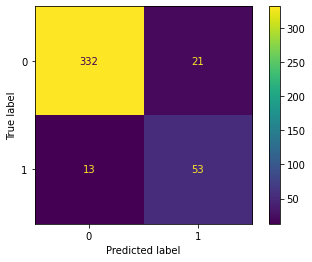

In [4]:
from sklearn import metrics

pred_lr = pipe_lr.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_lr)

In [5]:
score_lr = pipe_lr.predict_proba(test["text"])[:,1]

SVCでも同様です。

In [6]:
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC(class_weight="balanced"))
])
pipe_svc.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f14148ea9d0>)),
                ('clf', SVC(class_weight='balanced'))])

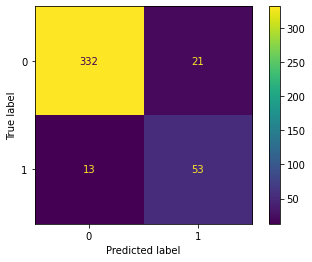

In [7]:
from sklearn import metrics

pred_svc = pipe_lr.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_svc)

In [8]:
score_svc = pipe_svc.decision_function(test["text"])

## 参考: PRカーブの比較

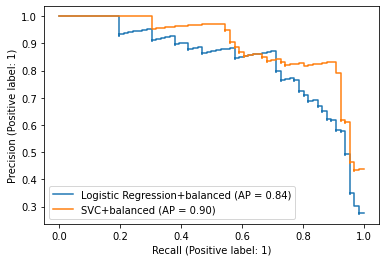

In [9]:
import  matplotlib.pyplot as plt

_, ax = plt.subplots()
for name, pred in [
    ("Logistic Regression+balanced", score_lr),
    ("SVC+balanced", score_svc),
]:
    metrics.PrecisionRecallDisplay.from_predictions(ax=ax, y_true=test["label_num"], y_pred=pred, name=name)